In [2]:
import pandas as pd

In [3]:
df = pd.read_csv(r'C:\Users\kesav\Guvi\guvi main\capstone4\Copper_Set.xlsx - Result 1.csv', low_memory=False)

In [4]:
def remove_invalid_material_ref(x):
    if isinstance(x, float) or x.startswith('00000'):
        return None
    else:
        return x

df['material_ref'] = df['material_ref'].apply(remove_invalid_material_ref)

In [5]:
df['quantity tons'] = pd.to_numeric(df['quantity tons'], errors='coerce')
df['item_date'] = pd.to_datetime(df['item_date'], format='%Y%m%d', errors='coerce').dt.date
df['delivery date'] = pd.to_datetime(df['delivery date'], format='%Y%m%d', errors='coerce').dt.date
df['country']=pd.to_numeric(df['country'], errors='coerce')
df['application']=pd.to_numeric(df['application'], errors='coerce')
df['customer']=pd.to_numeric(df['customer'], errors='coerce')

In [6]:
mapping = {
    '1': ['Won'],
    '2': ['Draft', 'To be approved', 'Lost', 'Not lost for AM', 'Revised', 'Offered', 'Offerable','Wonderful']
}

# Function to map categories
def map_categories(status):
    for key, values in mapping.items():
        if status in values:
            return key
    return status

# Apply mapping to the 'status' column
df['status'] = df['status'].apply(map_categories)

In [7]:
df.drop(columns=['id','material_ref'], inplace=True)
df = df.dropna()

In [8]:
inconsistent_dates =df[df['item_date'] > df['delivery date']]
print(inconsistent_dates.head())
inconsistent_dates.shape

     item_date  quantity tons    customer  country status item type  \
2   2021-04-01     386.127949  30153963.0     30.0      1        WI   
3   2021-04-01     202.411065  30349574.0     32.0      1         S   
4   2021-04-01     785.526262  30211560.0     28.0      1         W   
7   2021-04-01     113.387124  30342192.0     32.0      1         W   
11  2021-04-01     113.995666  30342192.0     32.0      1         W   

    application  thickness   width  product_ref delivery date  selling_price  
2          28.0       0.38   952.0       628377    2021-01-01         644.33  
3          59.0       2.30  1317.0   1668701718    2021-01-01         768.00  
4          10.0       4.00  2000.0       640665    2021-03-01         577.00  
7          41.0       0.68  1220.0       611993    2021-01-01         931.00  
11         41.0       0.55  1220.0       611993    2021-01-01         954.00  


(16107, 12)

In [9]:
replacement_date = df['delivery date'].mode()
df.loc[df['delivery date'] <df['item_date'], 'delivery date'] = replacement_date
inconsistent_dates_1 =df[df['item_date'] > df['delivery date']]
inconsistent_dates_1

,item_date,quantity tons,customer,country,status,item type,application,thickness,width,product_ref,delivery date,selling_price


In [10]:
df['item_year'] = df['item_date'].apply(lambda x: x.year)
df['item_month'] = df['item_date'].apply(lambda x: x.month)
df['item_day'] = df['item_date'].apply(lambda x: x.day)

# Alternatively, you can define a custom function to extract year, month, and day
def extract_date_components(date):
    return date.year, date.month, date.day

df['item_year'], df['item_month'], df['item_day'] = zip(*df['item_date'].apply(extract_date_components))

In [11]:
df['delivery date'] = pd.to_datetime(df['delivery date'], format='%Y%m%d', errors='coerce').dt.date
df['d_year'] = df['delivery date'].apply(lambda x: x.year)
df['d_month'] = df['delivery date'].apply(lambda x: x.month)
df['d_day'] = df['delivery date'].apply(lambda x: x.day)
df['d_year'], df['d_month'], df['d_day'] = zip(*df['delivery date'].apply(extract_date_components))

In [12]:
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
df['status'].unique()

array(['1', '2'], dtype=object)

In [14]:
def plot(df, column):
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    sns.boxplot(data=df, x=column)
    plt.title(f'Box Plot for {column}')

    plt.subplot(1,3,2)
    sns.histplot(data=df, x=column, kde=True, bins=50)
    plt.title(f'Distribution Plot for {column}')

    plt.subplot(1,3,3)
    sns.violinplot(data=df, x=column)
    plt.title(f'Violin Plot for {column}')
    plt.show()

In [15]:
df['item type'] = OrdinalEncoder().fit_transform(df[['item type']])

In [16]:
df['status']=OrdinalEncoder().fit_transform(df[['status']])

In [17]:
df['status'].unique()

array([0., 1.])

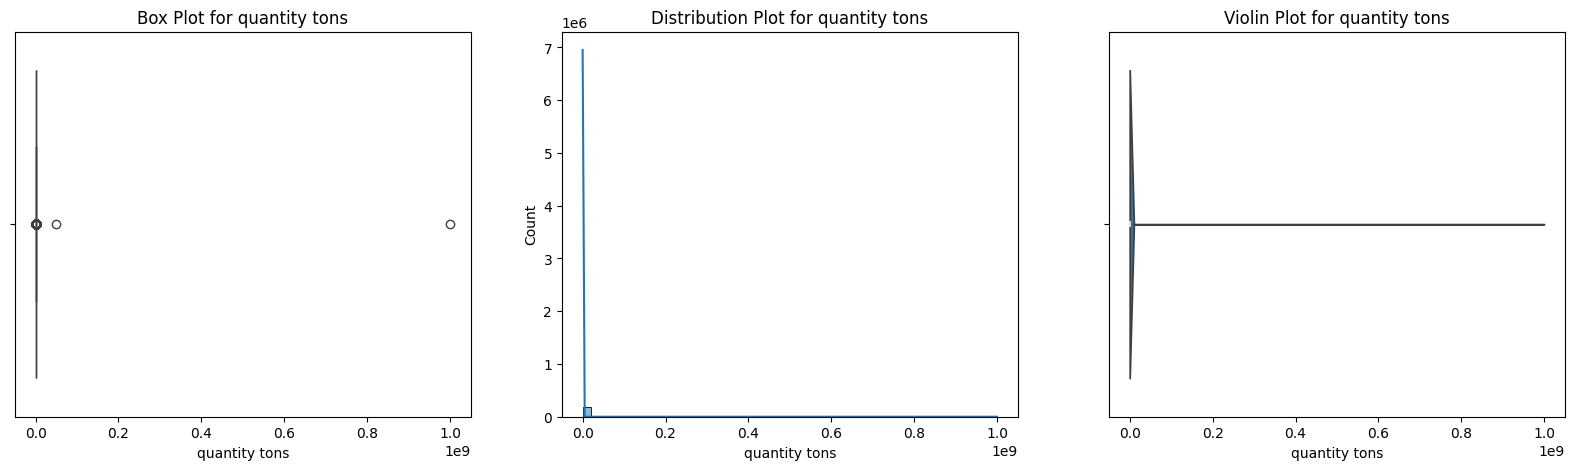

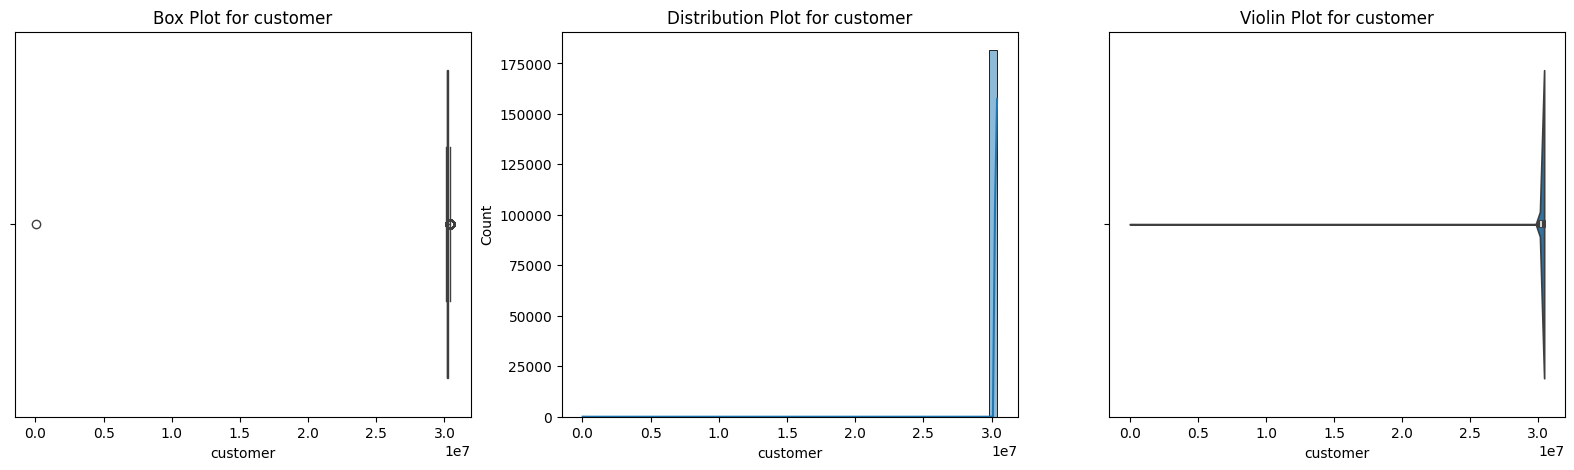

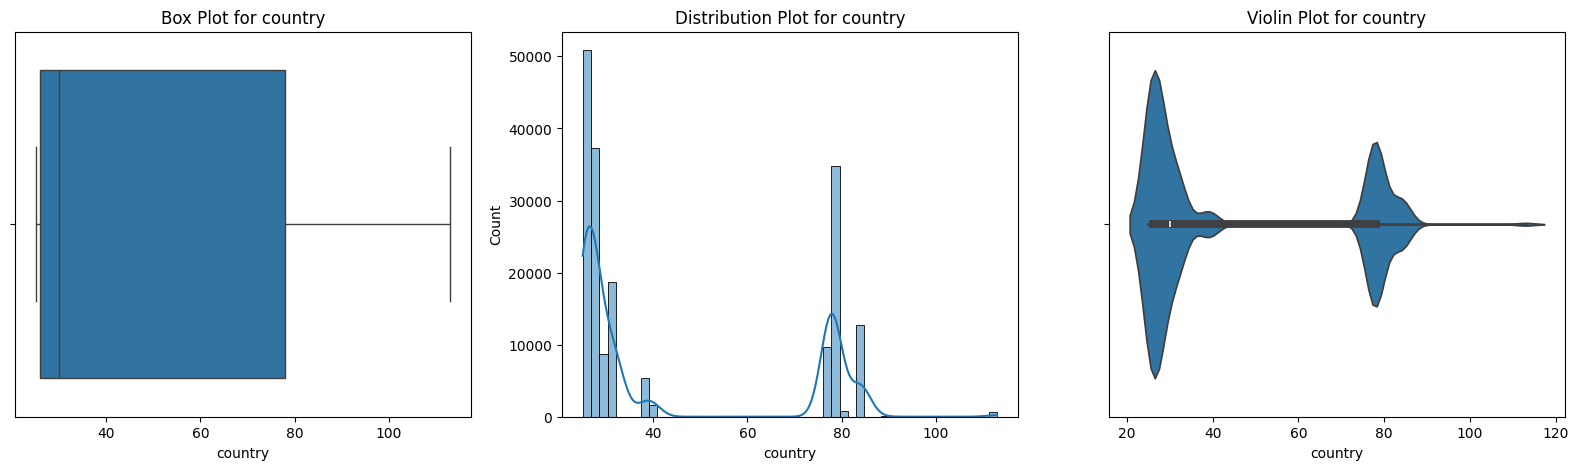

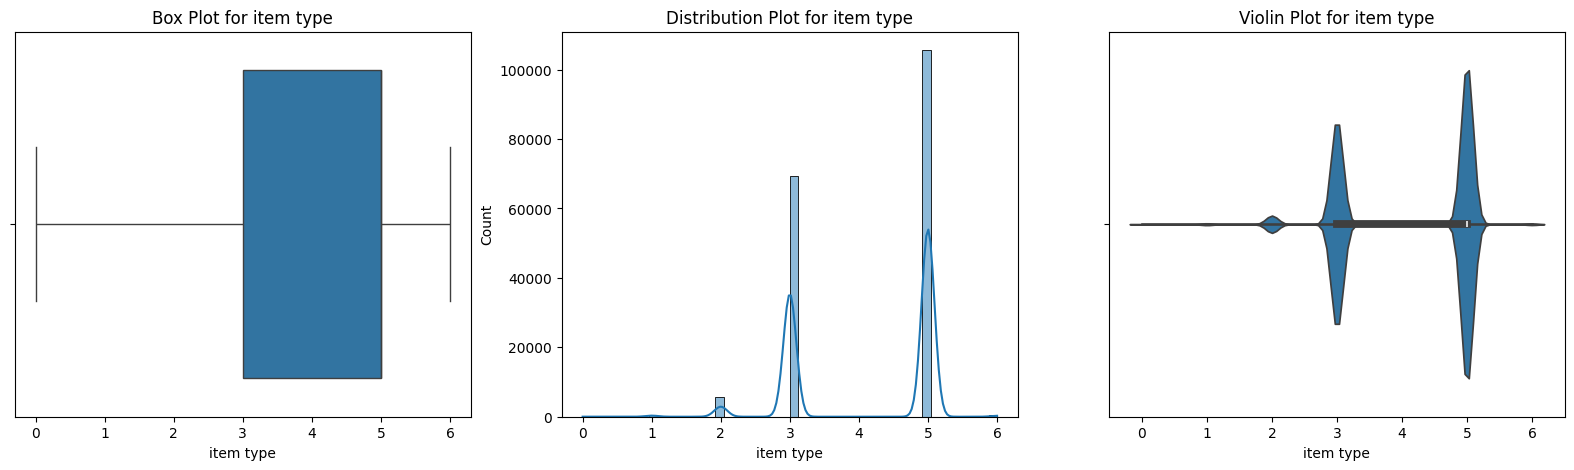

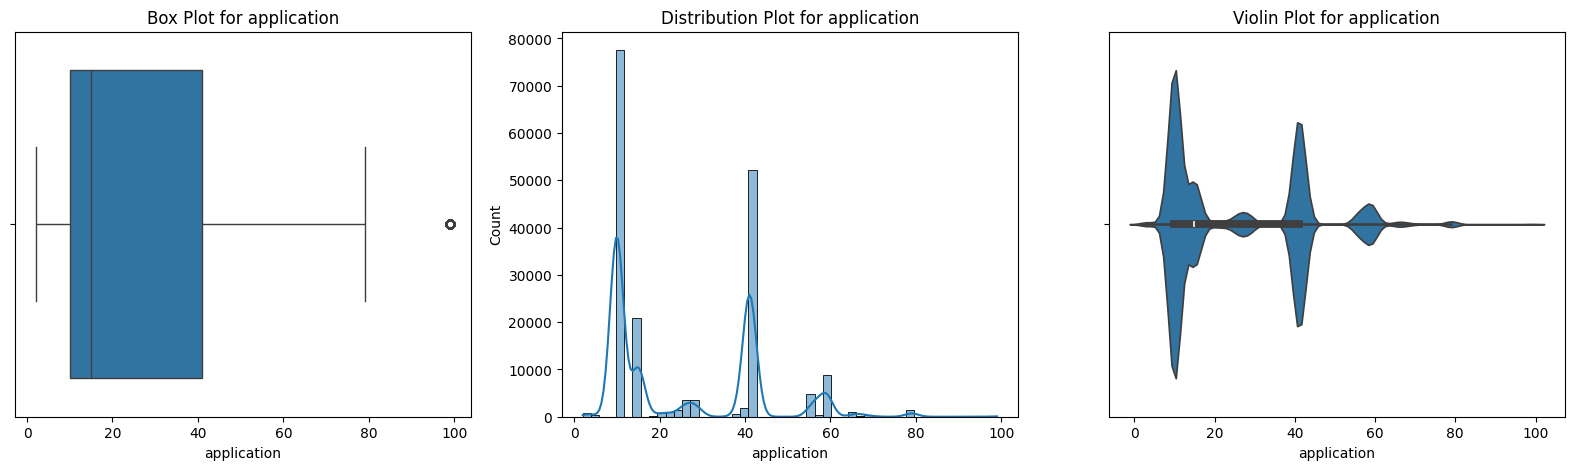

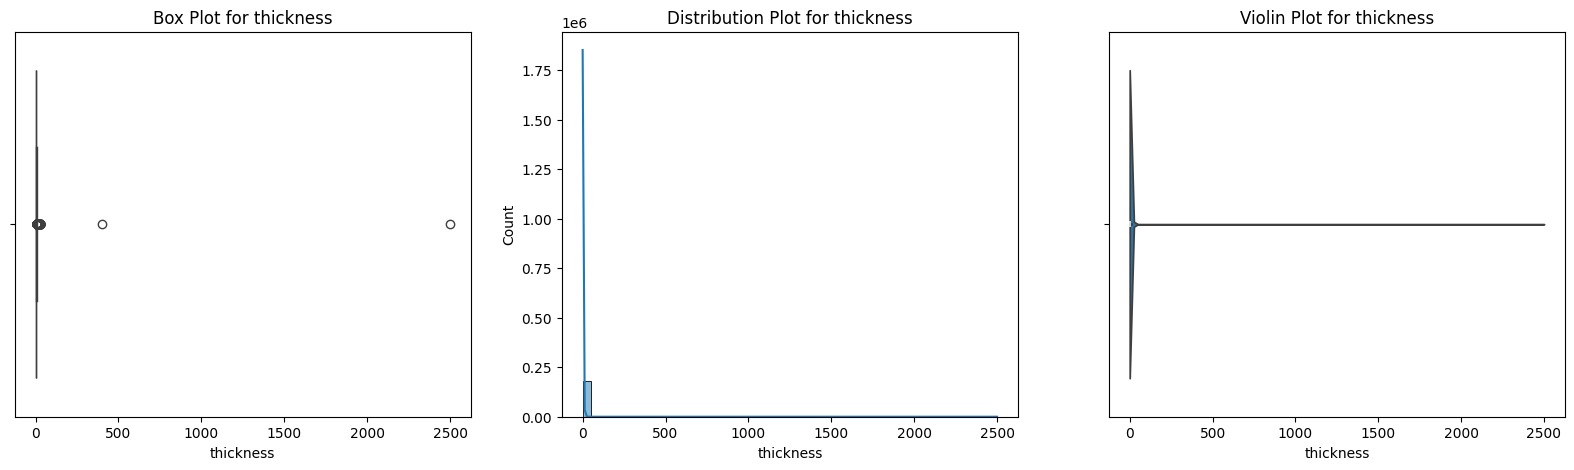

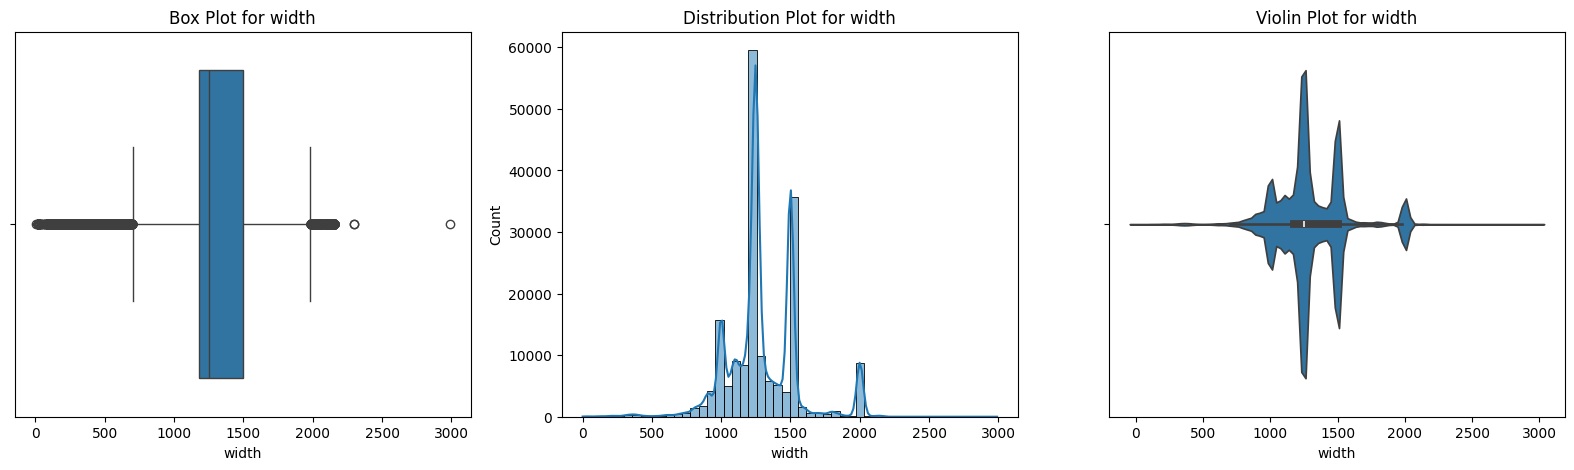

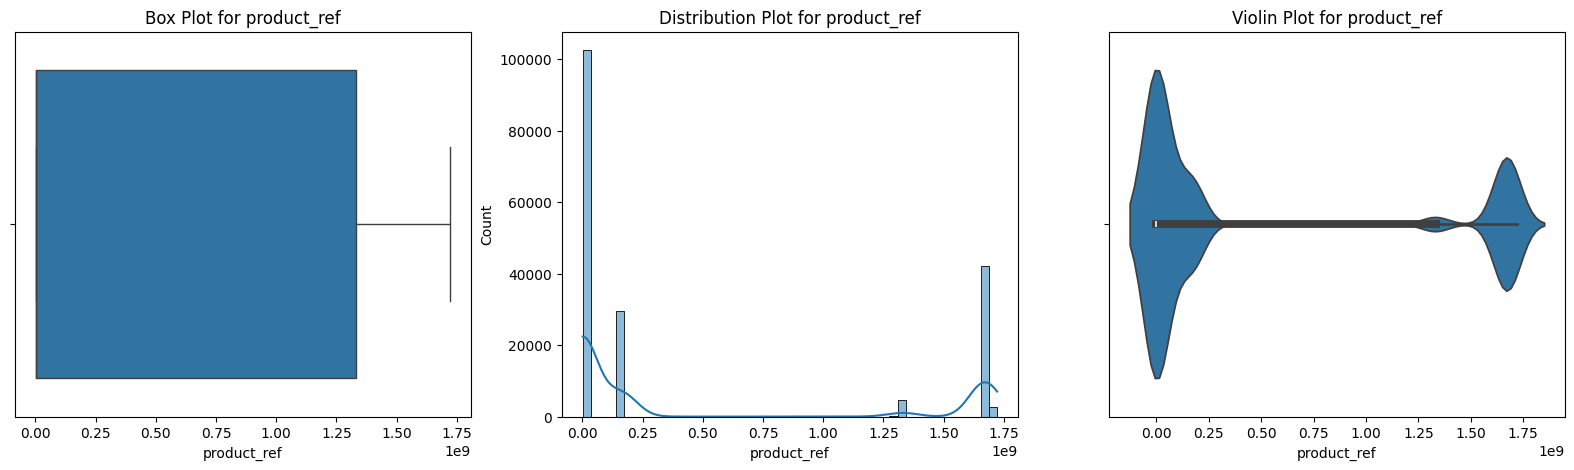

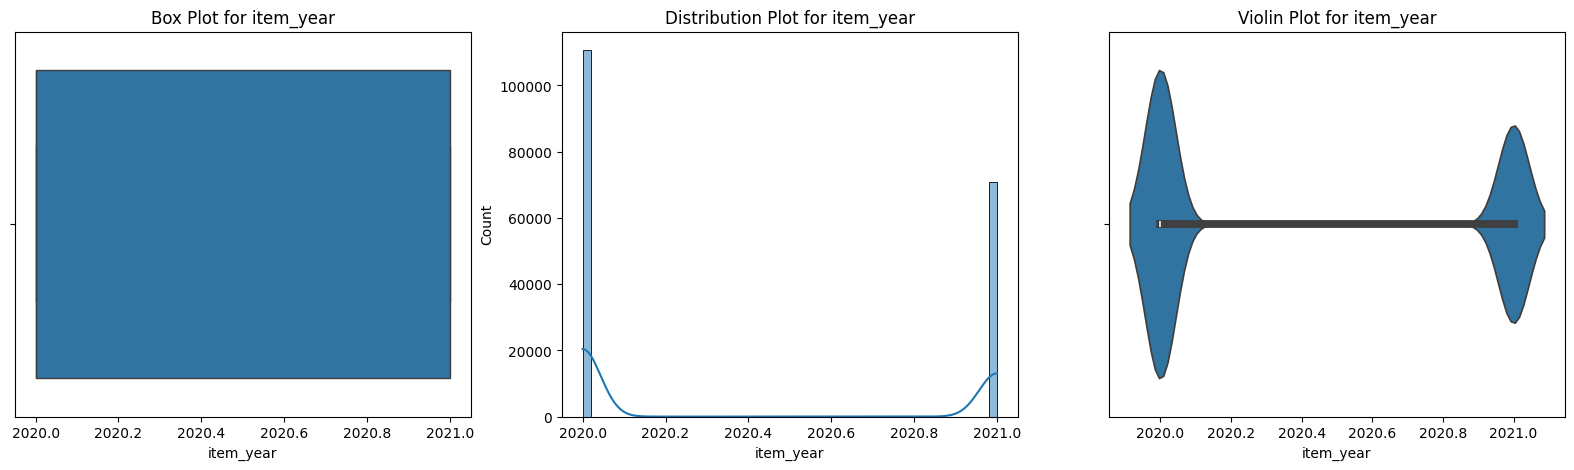

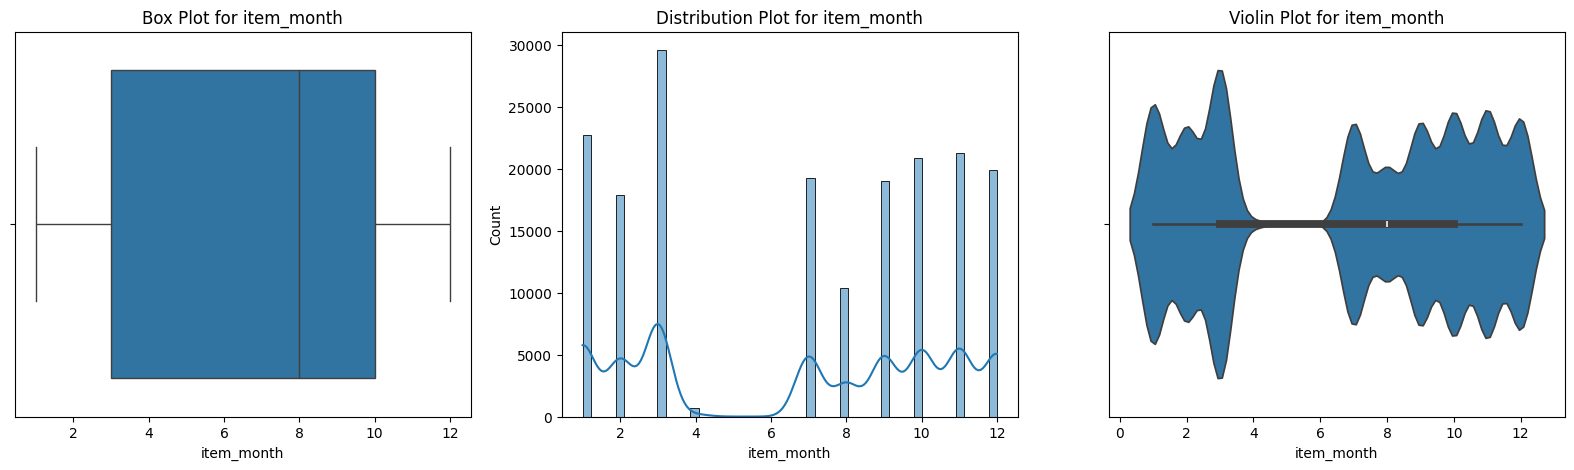

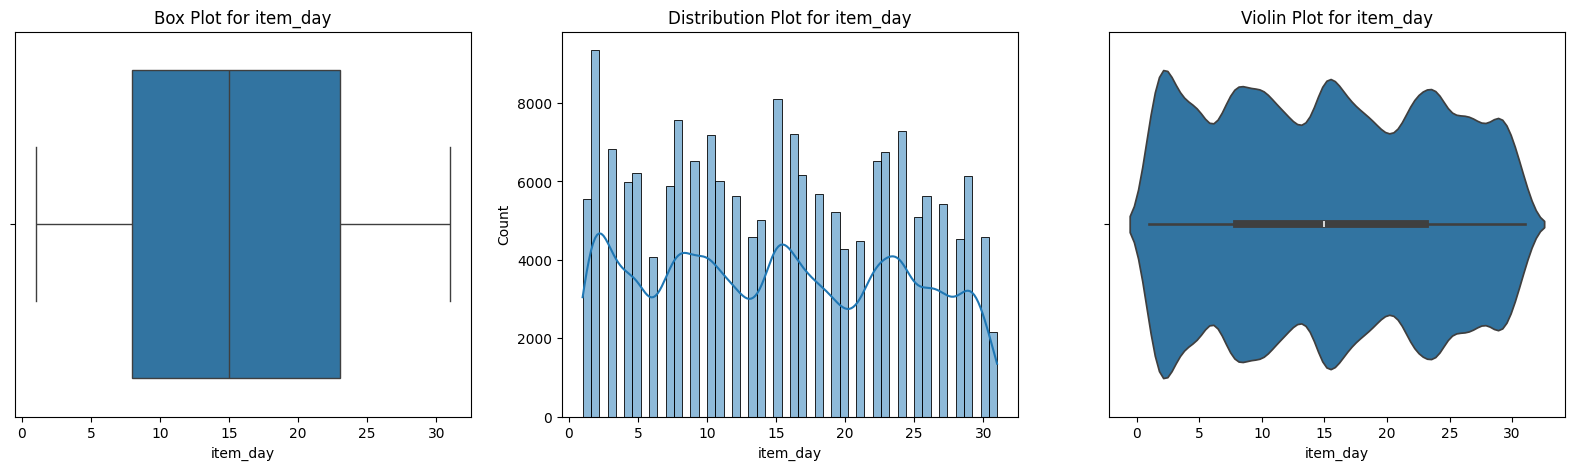

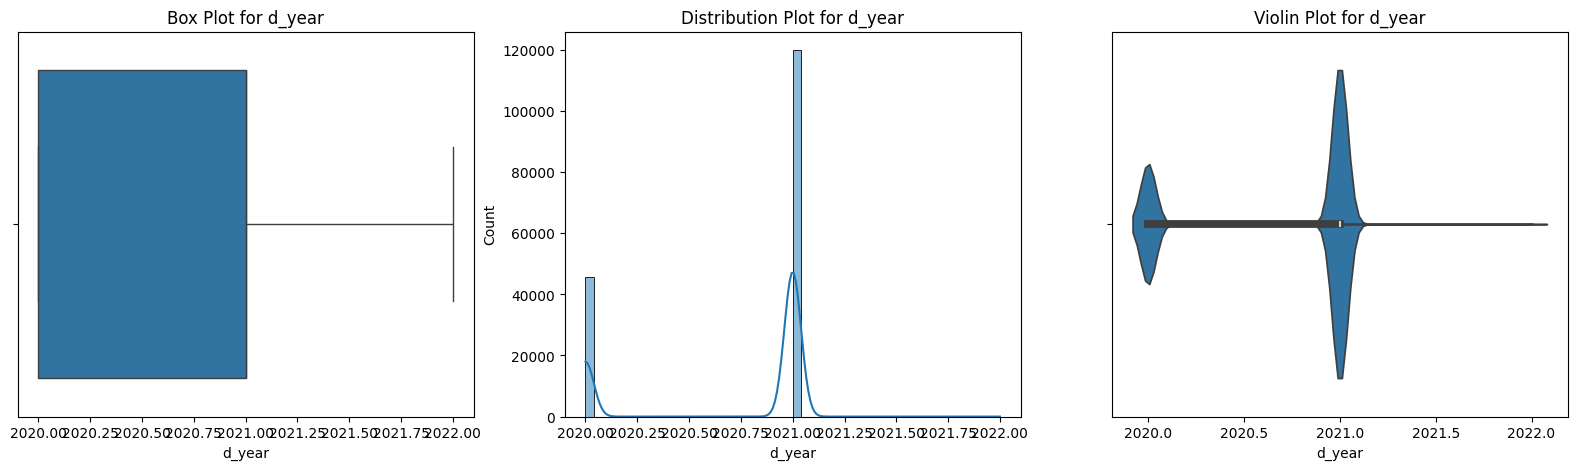

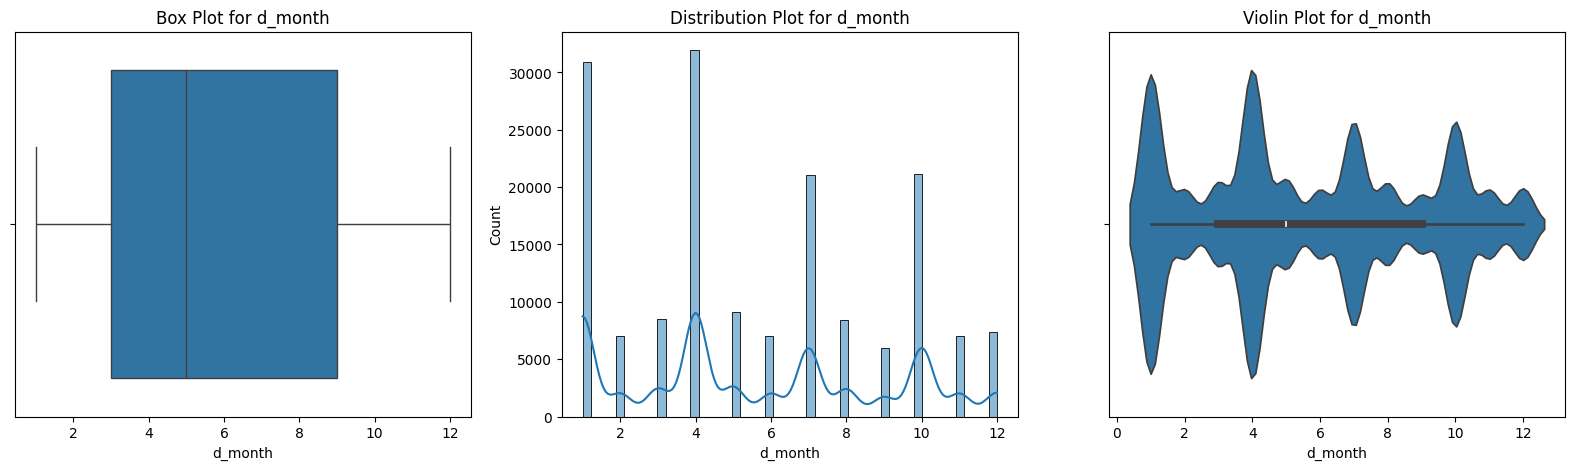

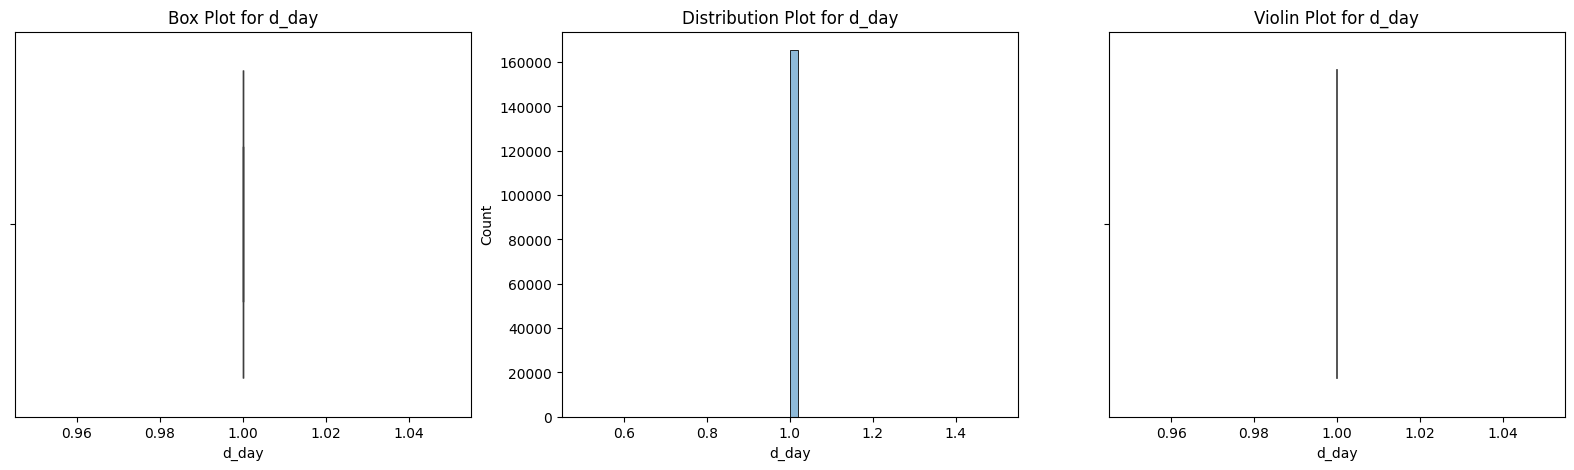

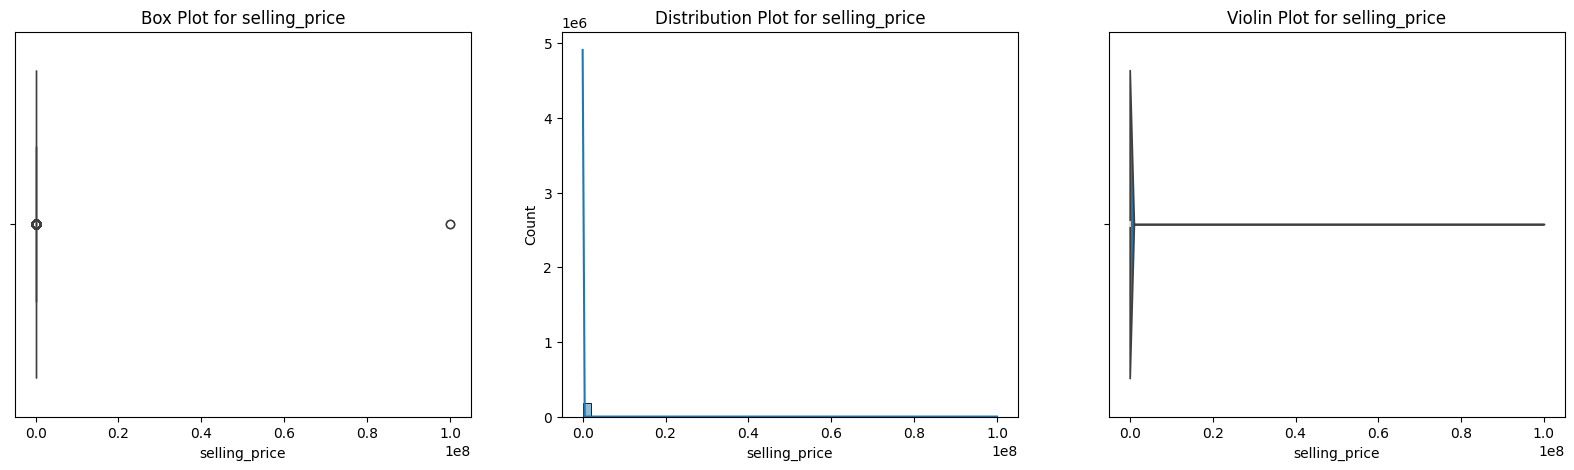

In [18]:
for i in ['quantity tons', 'customer', 'country',
       'item type', 'application', 'thickness', 'width', 'product_ref', 'item_year', 'item_month', 'item_day',
       'd_year', 'd_month', 'd_day','selling_price']:
    plot(df, i)

In [19]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

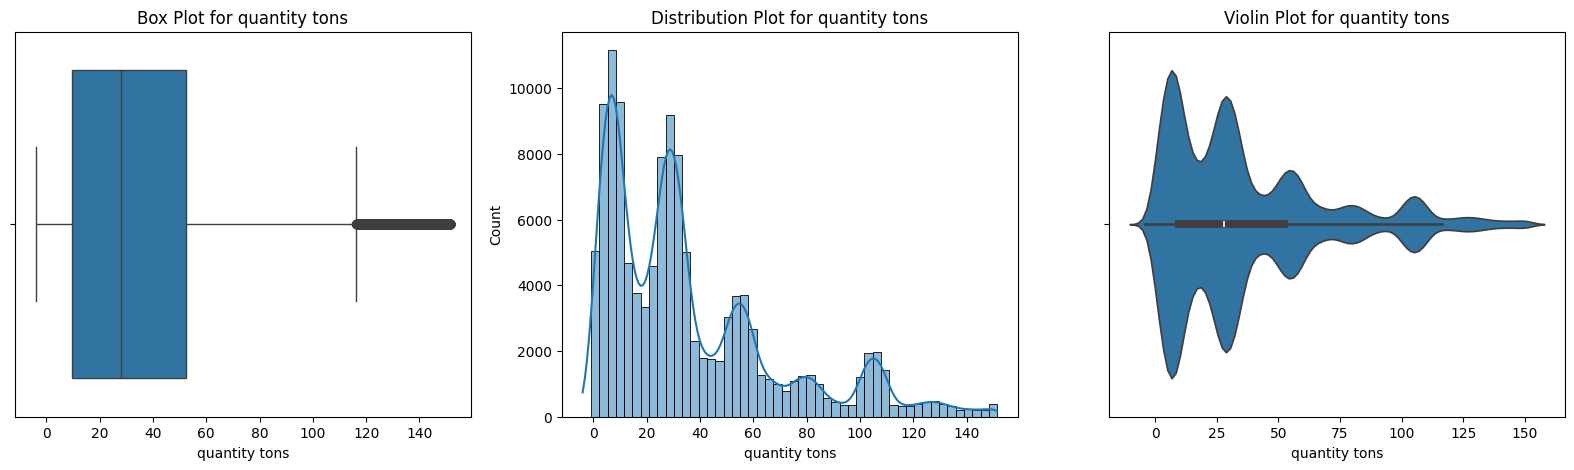

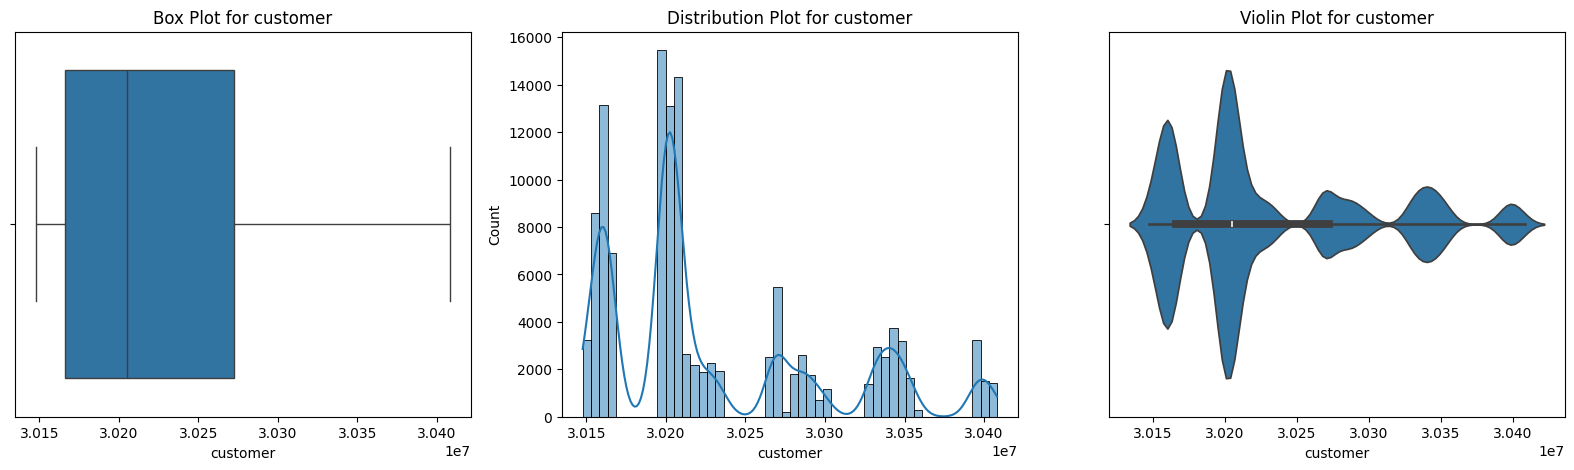

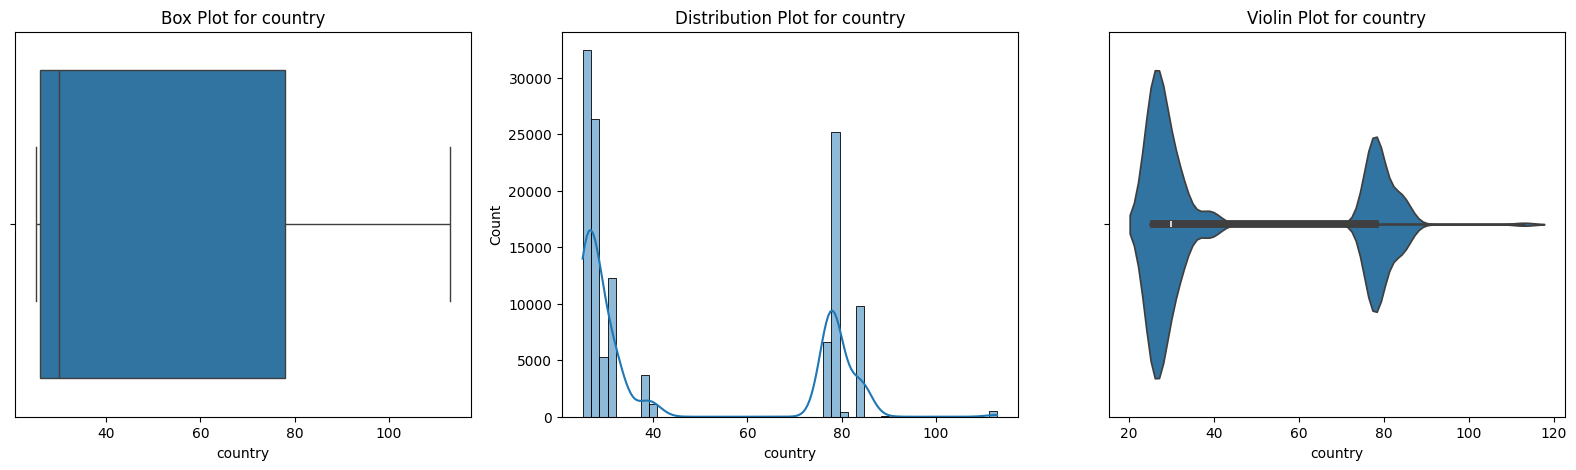

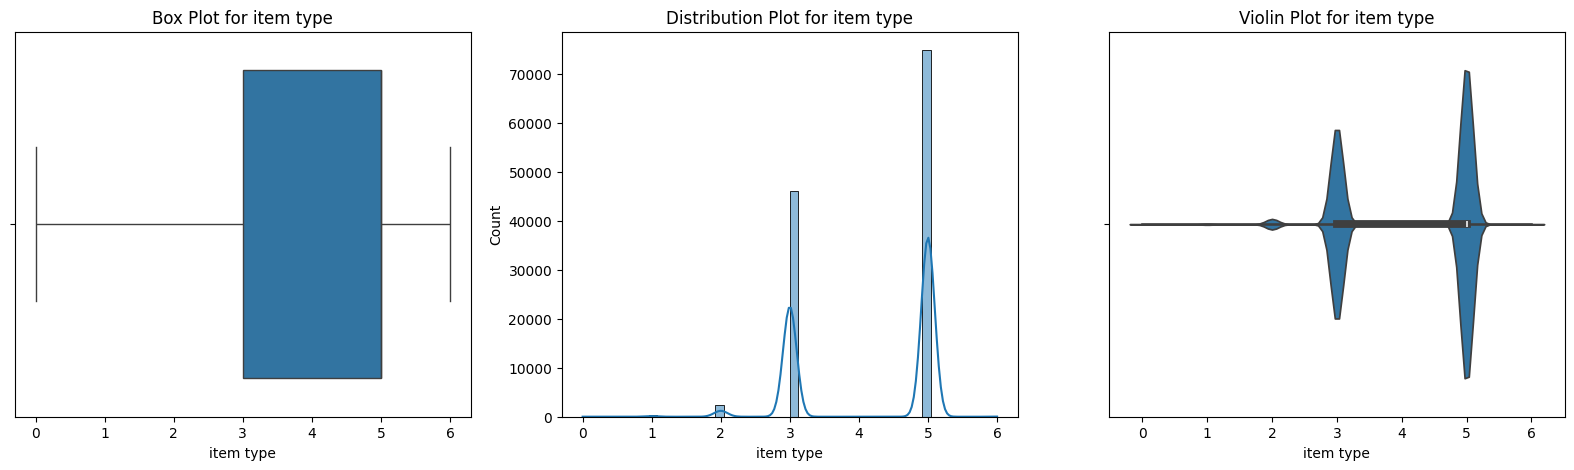

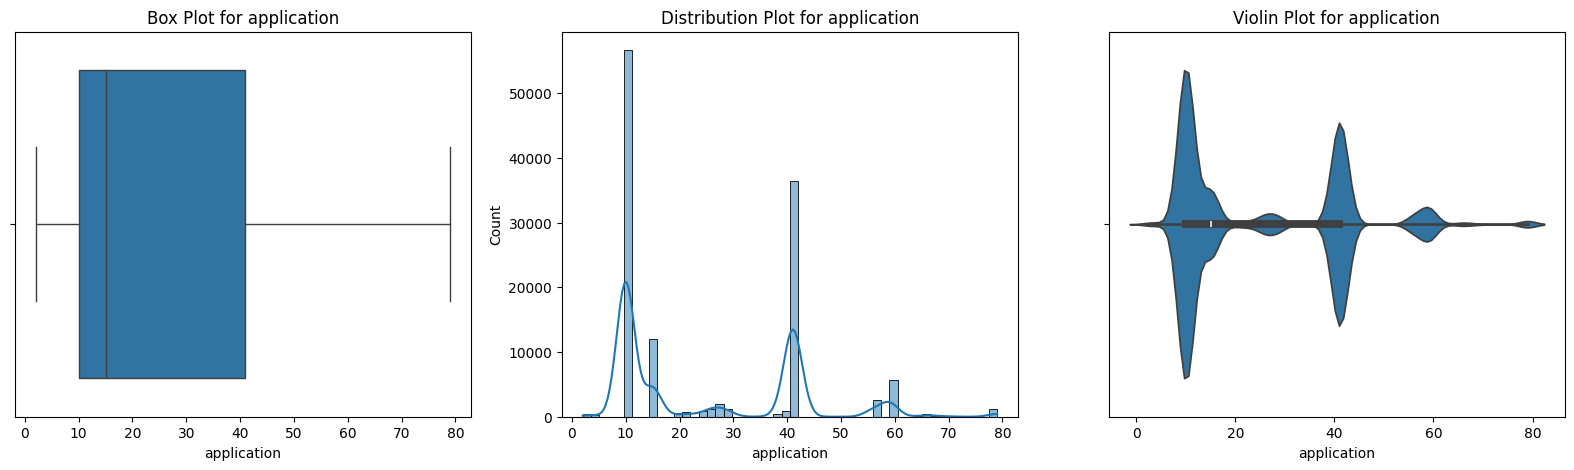

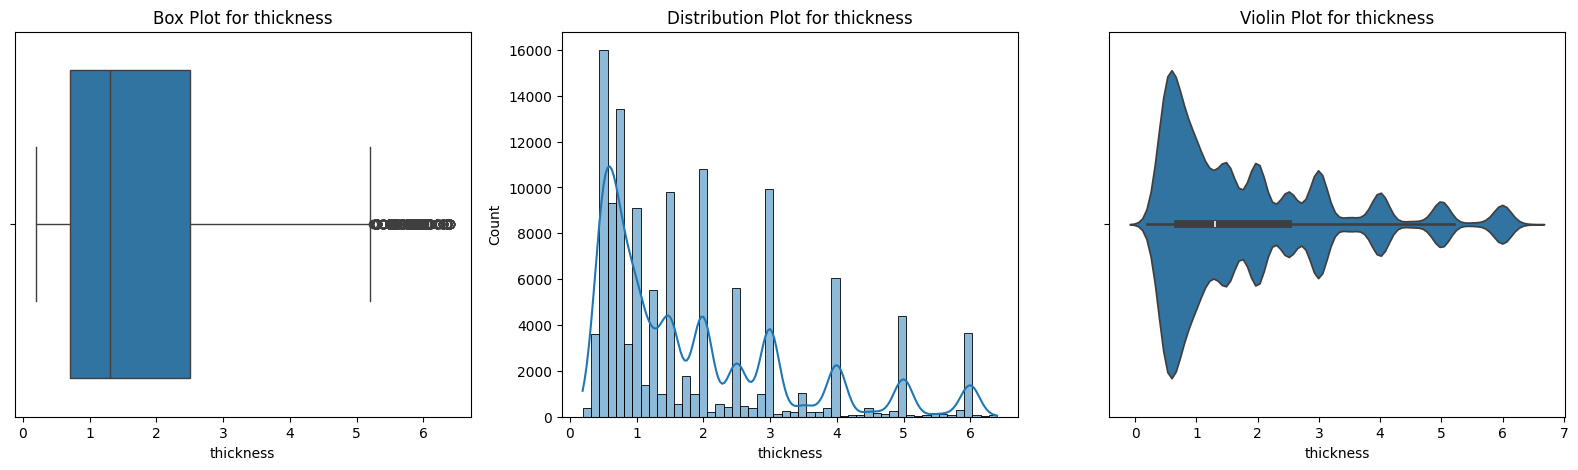

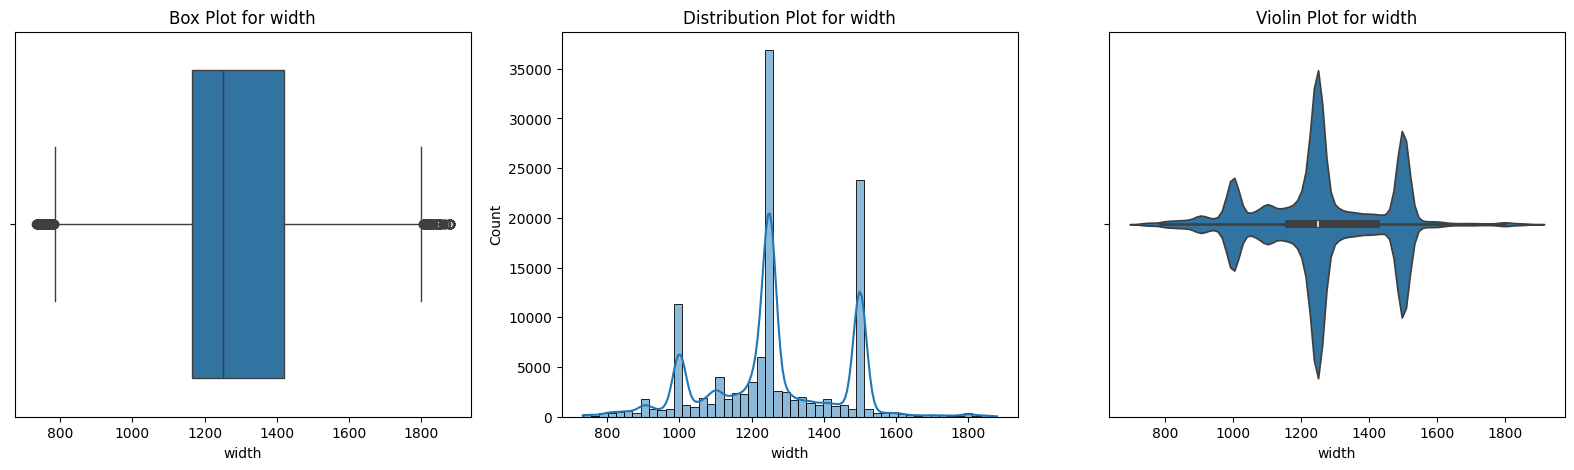

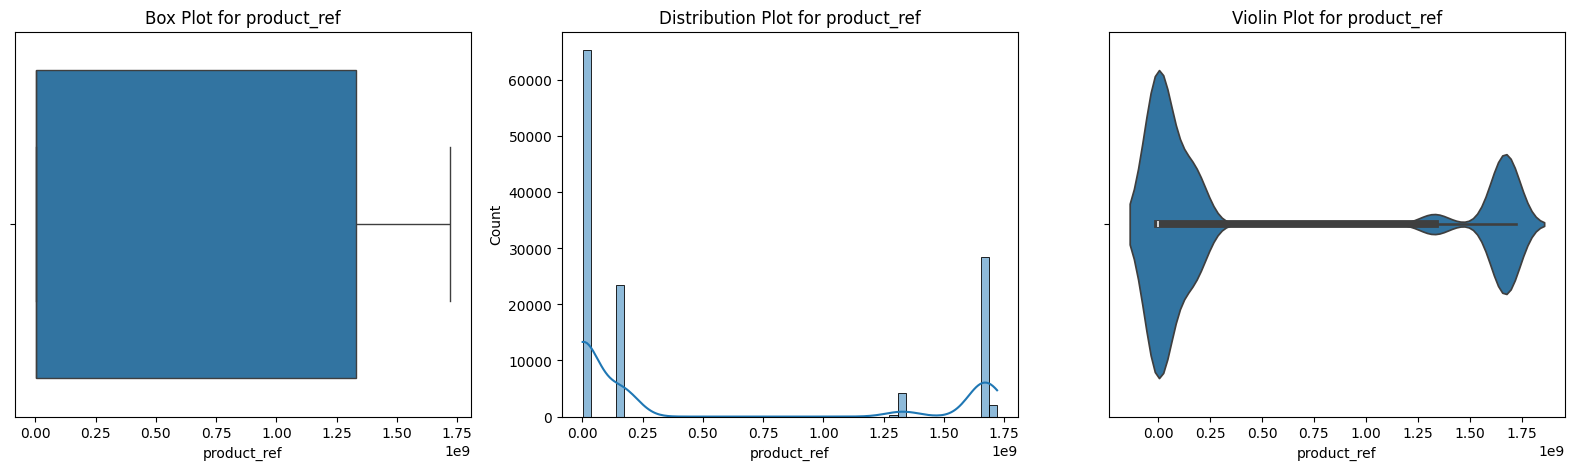

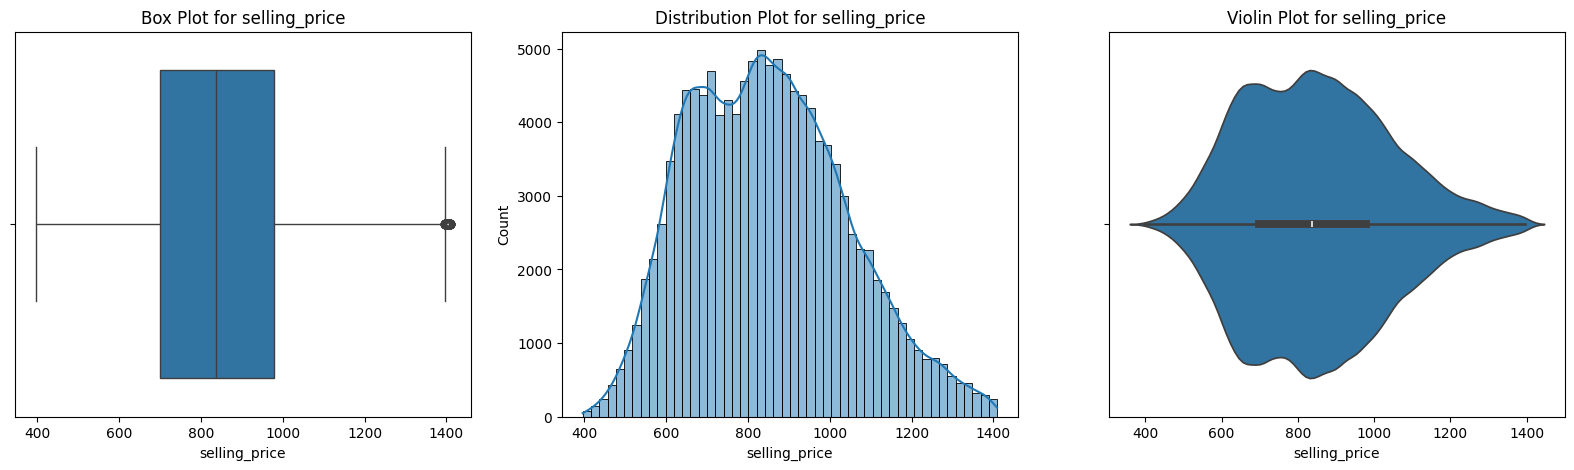

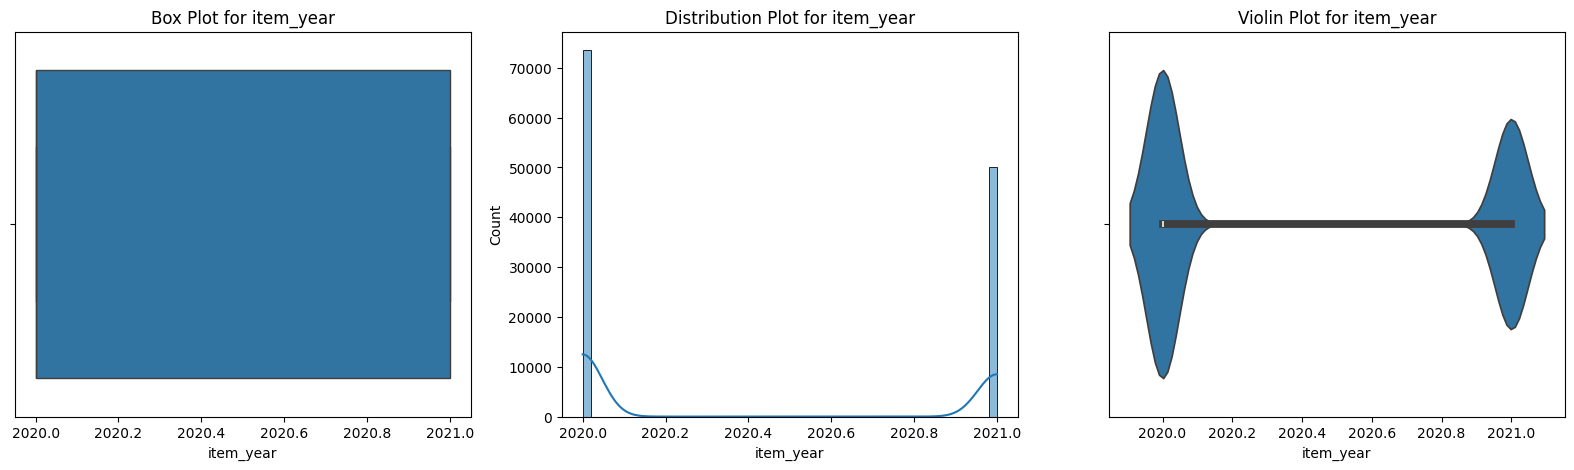

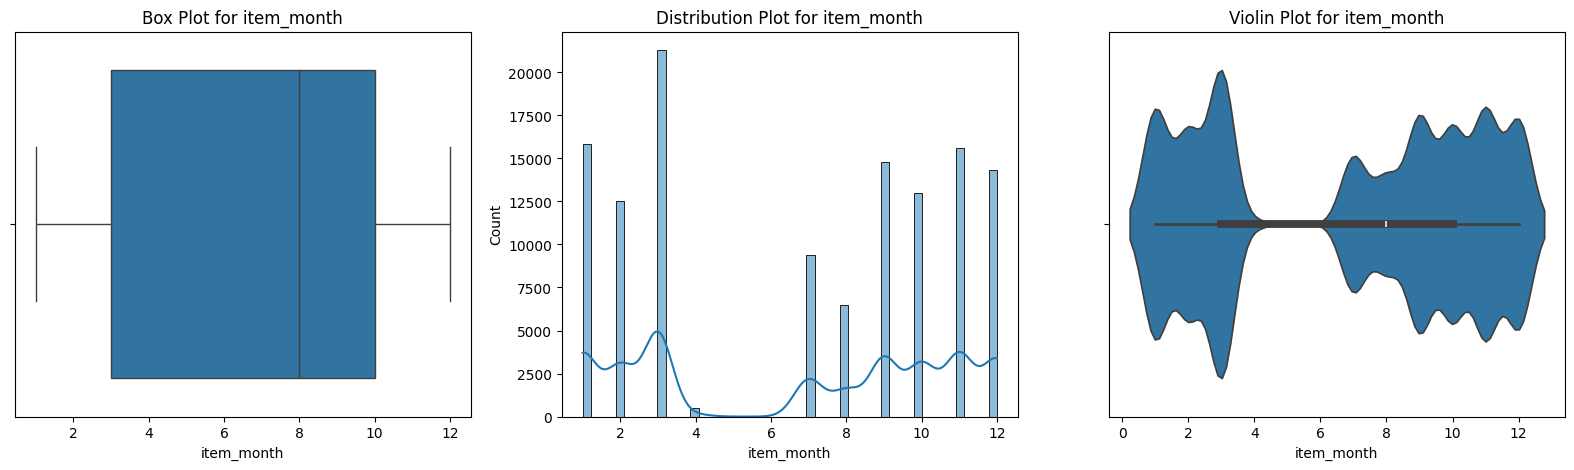

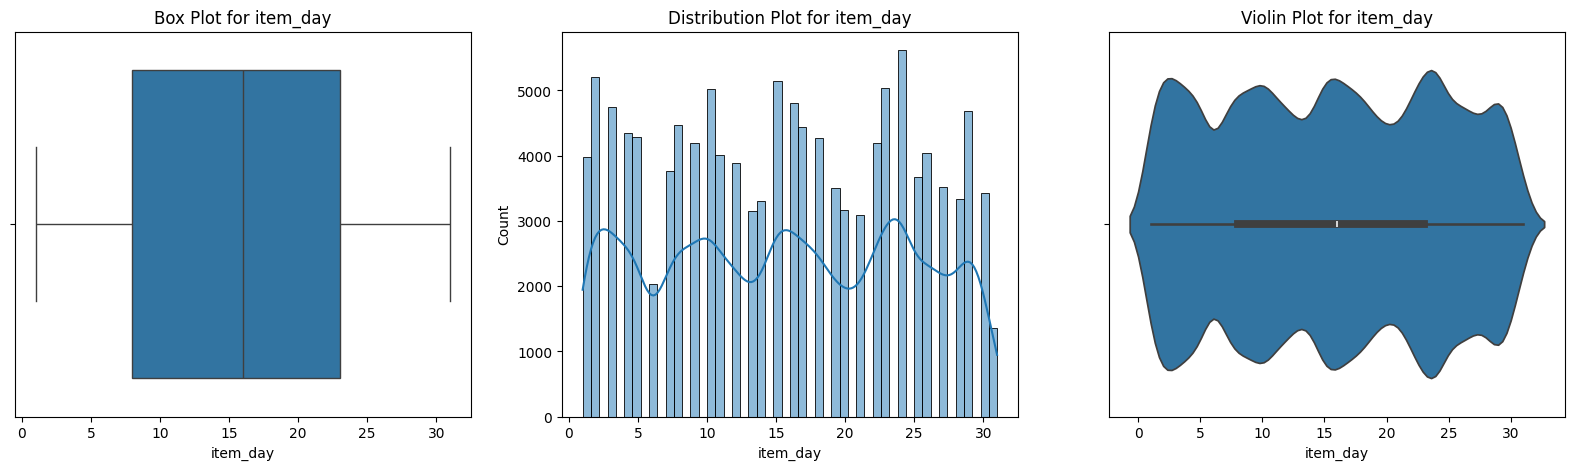

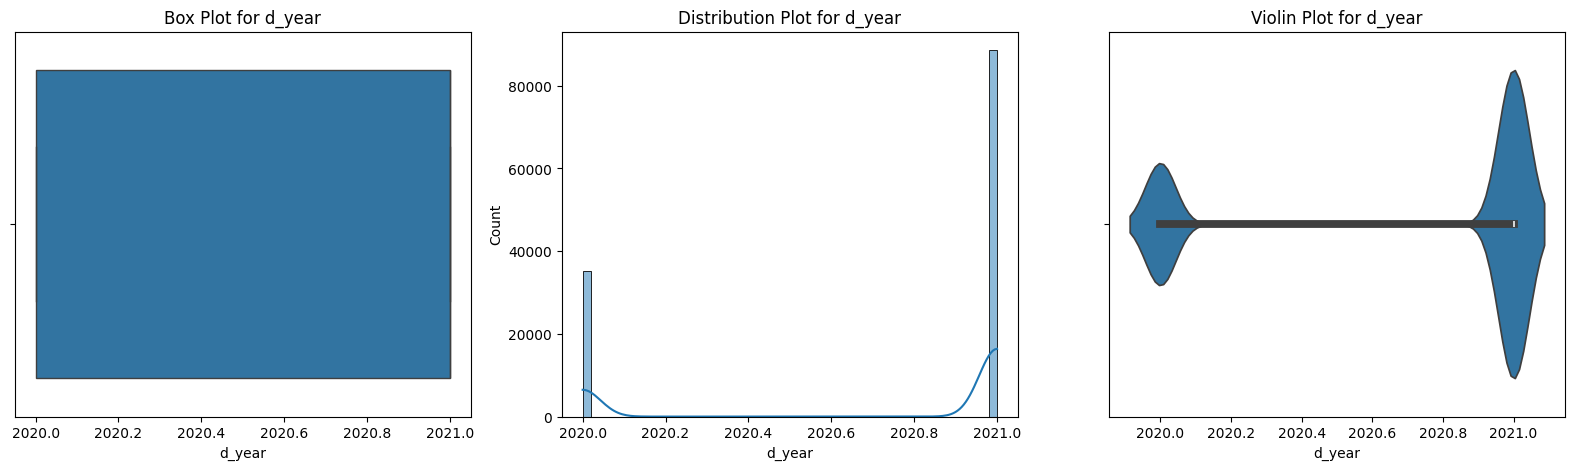

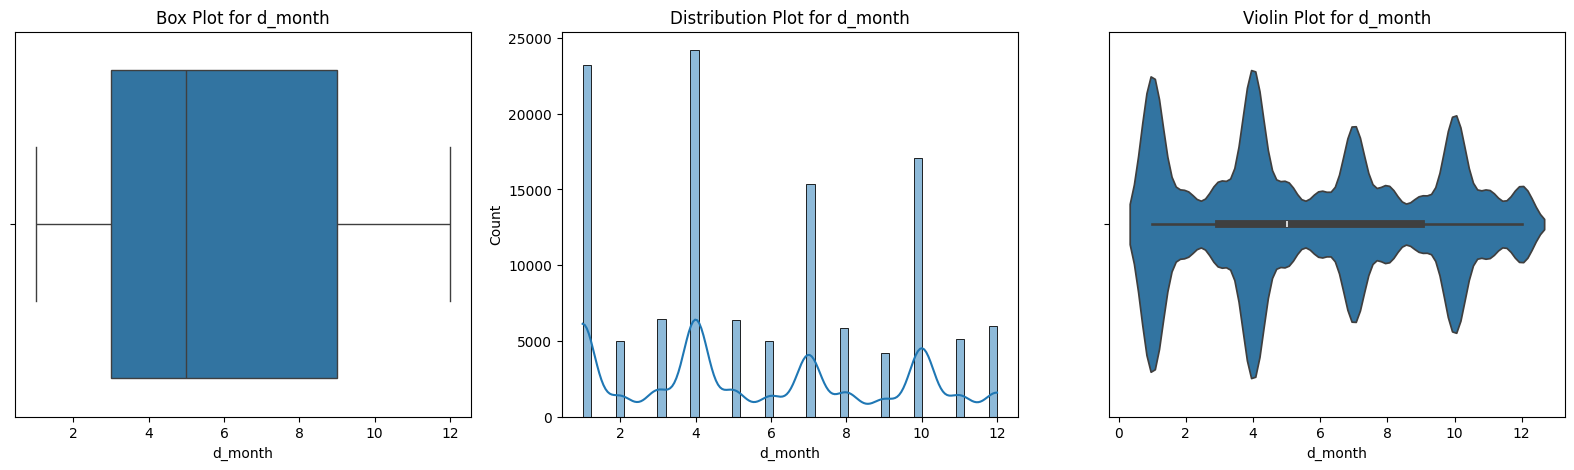

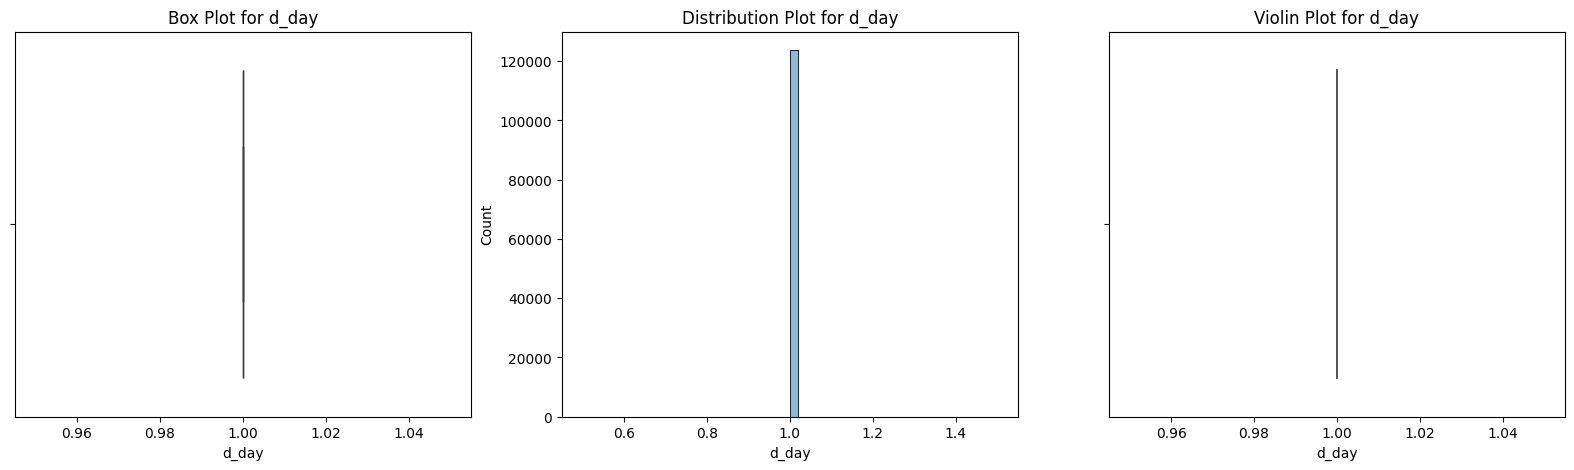

In [20]:
numeric_cols=['quantity tons', 'customer', 'country',
       'item type', 'application', 'thickness', 'width', 'product_ref','item_year', 'item_month', 'item_day',
       'd_year', 'd_month', 'd_day','selling_price']
for column in numeric_cols:
    df = remove_outliers_iqr(df, column)
for i in ['quantity tons', 'customer', 'country',
       'item type', 'application', 'thickness', 'width', 'product_ref',
        'selling_price', 'item_year', 'item_month', 'item_day',
       'd_year', 'd_month', 'd_day']:
    plot(df, i)

In [21]:
df['d_day']=df['d_day'].astype(int)
df['d_month']=df['d_month'].astype(int)
df['d_year']=df['d_year'].astype(int)

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
feature=df[[ 'quantity tons', 'customer', 'country','application', 'thickness', 'width', 'product_ref',
       'item_year', 'item_month', 'item_day',
       'd_year', 'd_month', 'd_day','selling_price']]
#df['status']=df['status'].map({'WON': 1, 'LOST': 2})
#target=df['status']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature, df['status'], test_size=0.3, random_state=42)

In [23]:
df['status'].unique()

array([0., 1.])

In [24]:
y_train

118419    1.0
178342    1.0
43497     0.0
18516     0.0
121313    1.0
         ... 
172033    1.0
146359    0.0
1226      0.0
22205     0.0
176733    0.0
Name: status, Length: 86614, dtype: float64

In [25]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [26]:
# Predict on test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.6442983755825543
Confusion Matrix:
[[23917     0]
 [13204     0]]


In [36]:
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pickle

In [37]:
y_clf_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print('F1 Score:', f1_score(y_test, y_pred))

Accuracy: 0.6442983755825543
F1 Score: 0.0


In [35]:
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pickle

In [28]:
model_2 =  ExtraTreesClassifier()
model_2.fit(X_train, y_train)

ExtraTreesClassifier()

In [29]:
y_clf_pred = model_2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print('F1 Score:', f1_score(y_test, y_pred))

Accuracy: 0.6442983755825543
F1 Score: 0.0


In [30]:
with open('model_2.pkl', 'wb') as f:
    pickle.dump(model_2, f)

In [31]:
X_clf_columns = feature.columns
with open('X_clf_columns.pkl', 'wb') as f:
    pickle.dump(X_clf_columns, f)

In [34]:
X_train.columns

Index(['quantity tons', 'customer', 'country', 'application', 'thickness',
       'width', 'product_ref', 'item_year', 'item_month', 'item_day', 'd_year',
       'd_month', 'd_day', 'selling_price'],
      dtype='object')

In [33]:
df.head()

,item_date,quantity tons,customer,country,status,item type,application,thickness,width,product_ref,delivery date,selling_price,item_year,item_month,item_day,d_year,d_month,d_day
0,2021-04-01,54.151139,30156308.0,28.0,0.0,5.0,10.0,2.00,1500.0,1670798778,2021-07-01,854.0,2021,4,1,2021,7,1
8,2021-04-01,69.071853,30341428.0,38.0,0.0,3.0,10.0,0.60,1275.0,1668701376,2021-07-01,1363.0,2021,4,1,2021,7,1
12,2021-04-01,27.512545,30165529.0,78.0,0.0,5.0,10.0,0.75,1250.0,164141591,2021-07-01,1098.0,2021,4,1,2021,7,1
13,2021-04-01,32.235317,30202362.0,27.0,0.0,3.0,10.0,0.60,1010.0,628377,2021-07-01,973.0,2021,4,1,2021,7,1
14,2021-04-01,10.411350,30271717.0,28.0,1.0,5.0,10.0,0.60,1250.0,611993,2021-07-01,1258.0,2021,4,1,2021,7,1
